# Output Transformations

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch

import sys
sys.path.append('../src')
from transformations import StandardizeTransform, LogTransform, BilogTransform

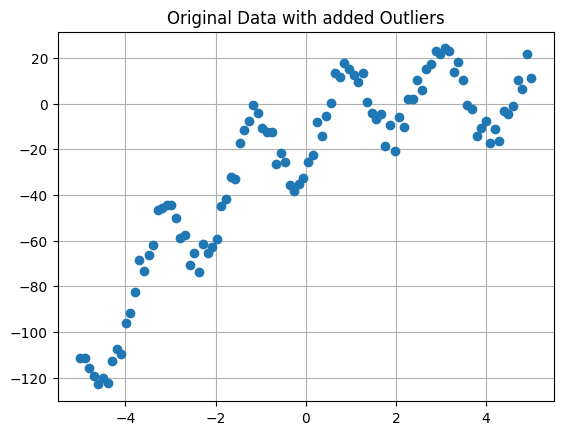

In [26]:
np.random.seed(0)

x = np.linspace(-5, 5, 100)
# y = np.sinh(x) * np.random.rand(100) * 105
#y = -2*(x-3)**2 + np.cos(3*(x-3))*20 + 140
y = -2*(x-3)**2 + np.cos(3*(x-3))*20 

# Add outliers
#FACTOR = 50  # Define FACTOR here
#y[::10] += FACTOR * np.random.rand(10) * np.sign(np.random.rand(10) - 0.5)

# Add noise
# noise = 100 + 1000 * x
y += 15 * np.random.rand(100)

plt.plot(x, y, 'o')
plt.grid(True)
plt.title('Original Data with added Outliers')
plt.show()

## Standardization

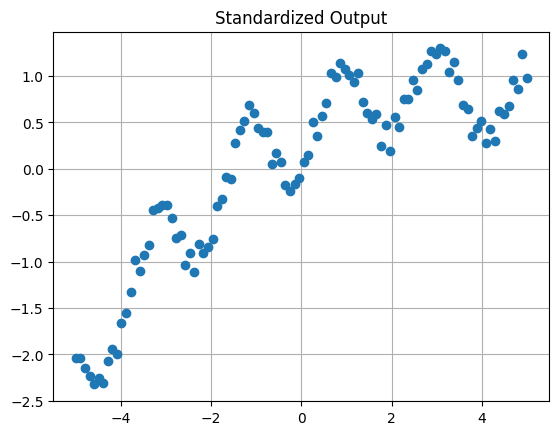

Mean: 0.00
Standard Deviation: 1.00


In [27]:
standardize_transform = StandardizeTransform()
y_standardized = standardize_transform(y)

plt.plot(x, y_standardized, 'o')
plt.title("Standardized Output")
plt.grid(True)
plt.show()

print(f"Mean: {np.mean(y_standardized):.2f}")
print(f"Standard Deviation: {np.std(y_standardized):.2f}")

## Log

NaN Values: False


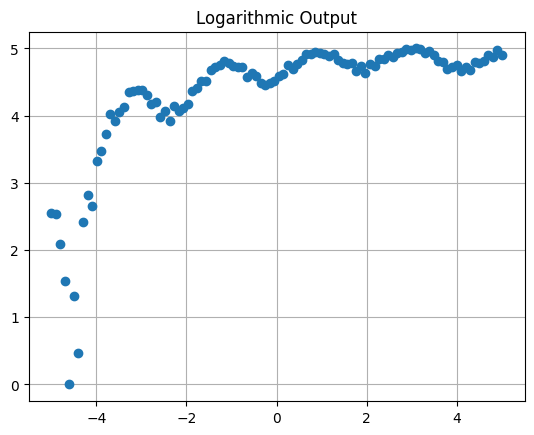

In [28]:
log_transform = LogTransform()
y_log = log_transform(torch.Tensor(y))

print(f"NaN Values: {np.any(np.isnan(y_log.numpy()))}")

plt.plot(x, y_log, 'o')
plt.title("Logarithmic Output")
plt.grid(True)
plt.show()

## Bilog

NaN Values: False


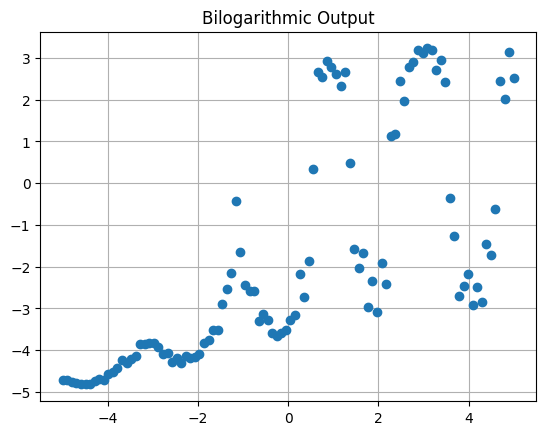

In [29]:
bilog_transform = BilogTransform()
y_bilog = bilog_transform(torch.Tensor(y))

print(f"NaN Values: {np.any(np.isnan(y_bilog.numpy()))}")

plt.plot(x, y_bilog.numpy(), 'o')  # Convert to NumPy array for plotting
plt.title("Bilogarithmic Output")
plt.grid(True)
plt.show()

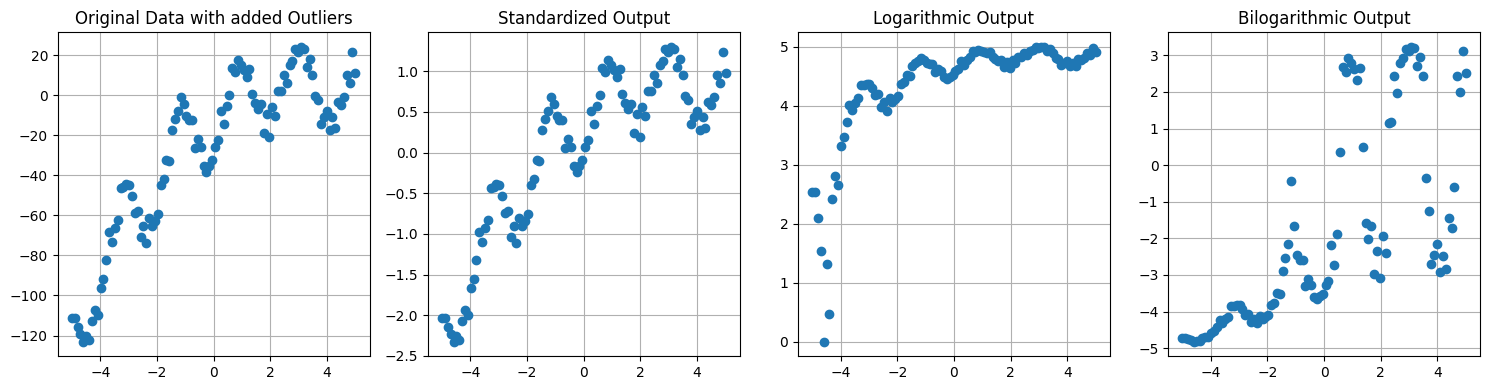

In [30]:
# Chart with all transformations
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.plot(x, y, 'o')
plt.title("Original Data with added Outliers")
plt.grid(True)
plt.subplot(1, 4, 2)
plt.plot(x, y_standardized, 'o')
plt.title("Standardized Output")
plt.grid(True)
plt.subplot(1, 4, 3)
plt.plot(x, y_log, 'o')
plt.title("Logarithmic Output")
plt.grid(True)
plt.subplot(1, 4, 4)
plt.plot(x, y_bilog, 'o')
plt.title("Bilogarithmic Output")
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparing GP Fits with Output Transformations using GPyTorch

/var/folders/q9/sfz8y7m9117c_szzcd5148h80000gn/T/ipykernel_60454/196124303.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_log = torch.tensor(y_log, dtype=torch.float32)
/var/folders/q9/sfz8y7m9117c_szzcd5148h80000gn/T/ipykernel_60454/196124303.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_bilog = torch.tensor(y_bilog, dtype=torch.float32)


NaN in original: False
NaN in standardized: False
NaN in log: False
NaN in bilog: False


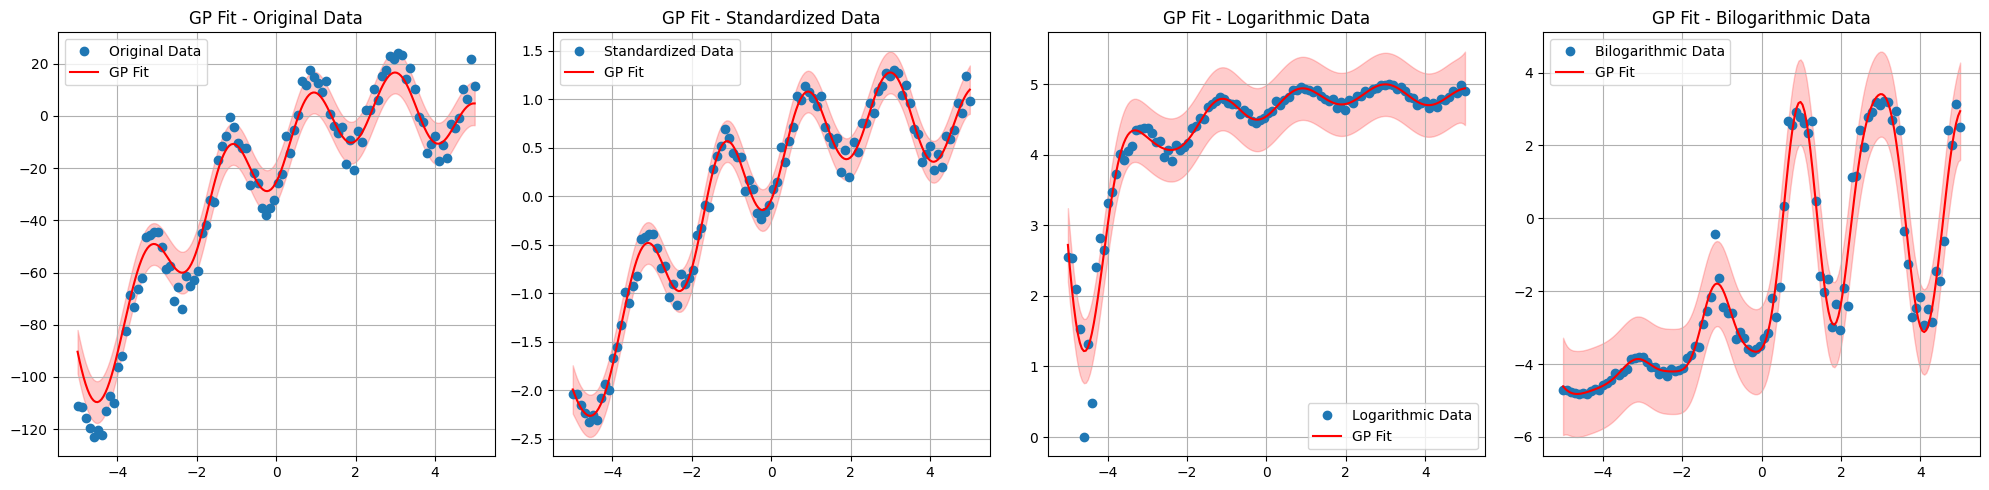

In [31]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Uuse already transformed data
train_x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
train_y_original = torch.tensor(y, dtype=torch.float32)
train_y_standardized = torch.tensor(y_standardized, dtype=torch.float32)
train_y_log = torch.tensor(y_log, dtype=torch.float32)
train_y_bilog = torch.tensor(y_bilog, dtype=torch.float32)

# Check for any NaN values in the training data
print(f"NaN in original: {torch.isnan(train_y_original).any().item()}")
print(f"NaN in standardized: {torch.isnan(train_y_standardized).any().item()}")
print(f"NaN in log: {torch.isnan(train_y_log).any().item()}")
print(f"NaN in bilog: {torch.isnan(train_y_bilog).any().item()}")

# Define likelihoods and models
likelihood_original = gpytorch.likelihoods.GaussianLikelihood()
model_original = ExactGPModel(train_x, train_y_original, likelihood_original)

likelihood_standardized = gpytorch.likelihoods.GaussianLikelihood()
model_standardized = ExactGPModel(train_x, train_y_standardized, likelihood_standardized)

likelihood_log = gpytorch.likelihoods.GaussianLikelihood()
model_log = ExactGPModel(train_x, train_y_log, likelihood_log)

likelihood_bilog = gpytorch.likelihoods.GaussianLikelihood()
model_bilog = ExactGPModel(train_x, train_y_bilog, likelihood_bilog)

# Training function
def train_gp(model, likelihood, train_x, train_y):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

# Train models
train_gp(model_original, likelihood_original, train_x, train_y_original)
train_gp(model_standardized, likelihood_standardized, train_x, train_y_standardized)
train_gp(model_log, likelihood_log, train_x, train_y_log)
train_gp(model_bilog, likelihood_bilog, train_x, train_y_bilog)

# Set models to evaluation mode
model_original.eval()
likelihood_original.eval()

model_standardized.eval()
likelihood_standardized.eval()

model_log.eval()
likelihood_log.eval()

model_bilog.eval()
likelihood_bilog.eval()

# Generate test points
test_x = torch.linspace(-5, 5, 200).unsqueeze(-1)

# Predictions
with torch.no_grad():
    pred_original = likelihood_original(model_original(test_x))
    pred_standardized = likelihood_standardized(model_standardized(test_x))
    pred_log = likelihood_log(model_log(test_x))
    pred_bilog = likelihood_bilog(model_bilog(test_x))

## Plot comparisons
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original
axes[0].plot(x, y, 'o', label='Original Data')
axes[0].plot(test_x.numpy().flatten(), pred_original.mean.numpy().flatten(), 'r-', label='GP Fit')
axes[0].fill_between(test_x.numpy().flatten(),
                     pred_original.mean.numpy().flatten() - 1.96 * pred_original.variance.sqrt().numpy().flatten(),
                     pred_original.mean.numpy().flatten() + 1.96 * pred_original.variance.sqrt().numpy().flatten(),
                     color='r', alpha=0.2)
axes[0].set_title('GP Fit - Original Data')
axes[0].legend()
axes[0].grid(True)

# Standardized
axes[1].plot(x, y_standardized, 'o', label='Standardized Data')
axes[1].plot(test_x.numpy().flatten(), pred_standardized.mean.numpy().flatten(), 'r-', label='GP Fit')
axes[1].fill_between(test_x.numpy().flatten(),
                     pred_standardized.mean.numpy().flatten() - 1.96 * pred_standardized.variance.sqrt().numpy().flatten(),
                     pred_standardized.mean.numpy().flatten() + 1.96 * pred_standardized.variance.sqrt().numpy().flatten(),
                     color='r', alpha=0.2)
axes[1].set_title('GP Fit - Standardized Data')
axes[1].legend()
axes[1].grid(True)

# Logarithmic
axes[2].plot(x, y_log, 'o', label='Logarithmic Data')
axes[2].plot(test_x.numpy().flatten(), pred_log.mean.numpy().flatten(), 'r-', label='GP Fit')
axes[2].fill_between(test_x.numpy().flatten(),
                     pred_log.mean.numpy().flatten() - 1.96 * pred_log.variance.sqrt().numpy().flatten(),
                     pred_log.mean.numpy().flatten() + 1.96 * pred_log.variance.sqrt().numpy().flatten(),
                     color='r', alpha=0.2)
axes[2].set_title('GP Fit - Logarithmic Data')
axes[2].legend()
axes[2].grid(True)

# Bilogarithmic
axes[3].plot(x, y_bilog, 'o', label='Bilogarithmic Data')
axes[3].plot(test_x.numpy().flatten(), pred_bilog.mean.numpy().flatten(), 'r-', label='GP Fit')
axes[3].fill_between(test_x.numpy().flatten(),
                     pred_bilog.mean.numpy().flatten() - 1.96 * pred_bilog.variance.sqrt().numpy().flatten(),
                     pred_bilog.mean.numpy().flatten() + 1.96 * pred_bilog.variance.sqrt().numpy().flatten(),
                     color='r', alpha=0.2)
axes[3].set_title('GP Fit - Bilogarithmic Data')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

## BoTorch Outcome Transformations

Compare BoTorch Transformations with Self-made Vanilla Transformations

In [32]:
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.outcome import Log
from botorch.models.transforms.outcome import Bilog

In [33]:
# Apply BoTorch Outcome Transformations
standardize_transform = Standardize(m=1)
log_transform = Log()  # Removed the 'epsilon' argument
bilog_transform = Bilog()

# Transform the data
y_standardized_botorch = standardize_transform(torch.tensor(y, dtype=torch.float32).unsqueeze(-1))
y_log_botorch = log_transform(torch.tensor(y, dtype=torch.float32).unsqueeze(-1))
y_bilog_botorch = bilog_transform(torch.tensor(y, dtype=torch.float32).unsqueeze(-1))

In [34]:
# Extract the transformed data from the tuple before converting to NumPy arrays
y_standardized_botorch = y_standardized_botorch[0].detach().numpy()
y_log_botorch = y_log_botorch[0].detach().numpy()
y_bilog_botorch = y_bilog_botorch[0].detach().numpy()

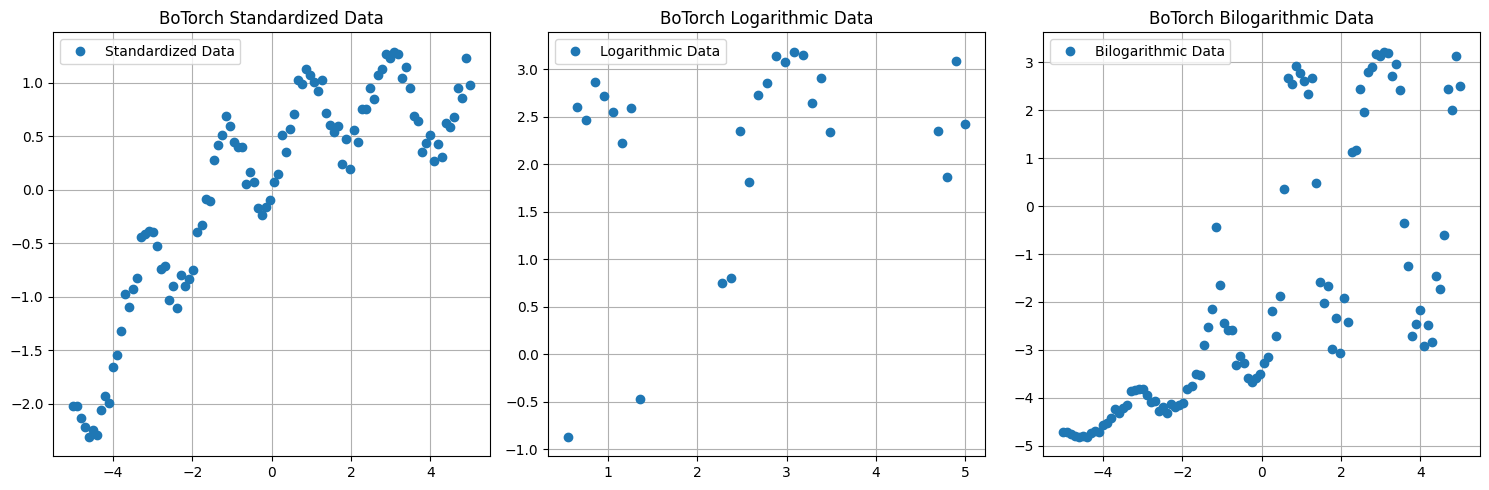

In [35]:
# Visualize the transformed data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Standardized
axes[0].plot(x, y_standardized_botorch.flatten(), 'o', label='Standardized Data')
axes[0].set_title('BoTorch Standardized Data')
axes[0].grid(True)
axes[0].legend()

# Logarithmic
axes[1].plot(x, y_log_botorch.flatten(), 'o', label='Logarithmic Data')
axes[1].set_title('BoTorch Logarithmic Data')
axes[1].grid(True)
axes[1].legend()

# Bilogarithmic
axes[2].plot(x, y_bilog_botorch.flatten(), 'o', label='Bilogarithmic Data')
axes[2].set_title('BoTorch Bilogarithmic Data')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()